In [1]:
"""
These are an ensemble of functions which allow:

1. reading a LAMMPS velocity trajectory file
2. extract the velocities, atom types and timesteps
3. calculate de auto-correlation function of the velocity
4. calculate its Fourier transform to obtain the spectral density
5. detect the peaks of this power spectrum
6. yield an array of modes calculated by molecular dynamics
7. compare it with the vibrational modes calculated by ab initio
8. minimize the difference function

The softwares used for inspiration are:

a. detect_peaks.py by Marcos Duarte
b. DynaPhoPy by Abel Carreras
c. Pwtools by El Corto

It depends on:

a. Numpy
b. Pandas (possibility of not using it in the future and replacing by numpy?)
c. Scipy
    
"""

'\nThese are an ensemble of functions which allow:\n\n1. reading a LAMMPS velocity trajectory file\n2. extract the velocities, atom types and timesteps\n3. calculate de auto-correlation function of the velocity\n4. calculate its Fourier transform to obtain the spectral density\n5. detect the peaks of this power spectrum\n6. yield an array of modes calculated by molecular dynamics\n7. compare it with the vibrational modes calculated by ab initio\n8. minimize the difference function\n\nThe softwares used for inspiration are:\n\na. detect_peaks.py by Marcos Duarte\nb. DynaPhoPy by Abel Carreras\nc. Pwtools by El Corto\n\nIt depends on:\n\na. Numpy\nb. Pandas (possibility of not using it in the future and replacing by numpy?)\nc. Scipy\n    \n'

In [2]:
import os
import numpy as np
from scipy import signal
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import convolve, fftconvolve, gaussian
from scipy import signal
%matplotlib inline

def read_traj(file='velocities.trj'):
    """
    Return the total number of timesteps (including the starting point), 
    the number of atoms, one array for atom's id for each timestep (in case they change order during timesteps),
    one array per timestep of the atomic masses of all atoms.
    Concerning the velocities, it returns three arrays, each one corresponding to one cartesian coordinate vx, vy, vz. 
    Each array contains a number of subarrays for each timestep.
    Each subarray contains data for each atom.
    """
    
    traj_patt = re.compile(r"^\d+\s+\d+(\.\d+)?\s+[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?\s+[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?\s+[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?")
    
    with open(file, 'r') as v:
        timestep = []
        atoms = []
        masses= []
        vel = [[] for i in range(3)] 
        
        for line in v:
            if 'ITEM: TIMESTEP' in line:
                timestep.append(int(v.readline()))
            elif 'NUMBER OF ATOMS' in line:
                noa = int(v.readline())
            elif traj_patt.search(line):
                atoms.append(int(line.split()[0]))
                masses.append(float(line.split()[1]))
                for i in range(3):
                    vel[i].append(float(line.split()[i+2]))
        
        atoms_id = np.array_split(atoms,len(atoms)//noa)
        masses = np.array_split(masses,len(masses)//noa)
        vel = np.array([np.array_split(vel[i], len(vel[i])//noa) for i in range(3)])
        
        
    return noa, np.array(timestep), np.array(atoms_id), np.array(masses), vel

n_of_atoms = read_traj()[0]
timesteps = read_traj()[1]
atoms_id = read_traj()[2]
masses = read_traj()[3]
vel = read_traj()[4]

In [3]:
def pyvacf(vel, m):
    """Reference implementation for calculating the VACF of velocities in 3d
    array `vel`. 

    Parameters
    ----------
    vel : 3d array, (3, nstep, natoms)
        Atomic velocities.
    m : 1d array (natoms,)
        Atomic masses.

    Returns
    -------
    c : 1d array (nstep,)
        VACF
    """
    natoms = vel.shape[2]
    nstep = vel.shape[1]
    c = np.zeros((nstep,), dtype=float)
    # c(t) = <v(t0) v(t0 + t)> / <v(t0)**2> = C(t) / C(0)
    for t in range(nstep):
        for j in range(nstep-t):
            for i in range(natoms):
                c[t] += np.dot(vel[:,j,i], vel[:,j+t,i]) * m[t][i]
                    
    c = c / c[0]
    return c

In [4]:
vacf = pyvacf(vel, masses)

In [13]:
vacf_sym = np.concatenate((vacf[::-1], vacf[1:]))
fourier = np.abs(fft(vacf_sym))

dt = 1
delta_t = dt * 1e-15
vc = 2.9979245899e10 

wavenumber = np.fft.fftfreq(len(fourier), delta_t * vc)[0:int(len(fourier) / 2)]
intensity = fourier[0:int(len(fourier)/2)]

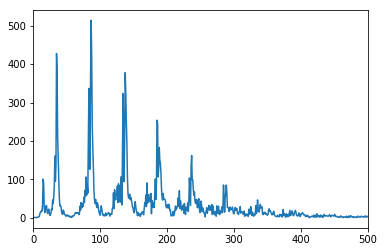

In [15]:
plt.plot(wavenumber, intensity)
plt.xlim(0, 500);

In [ ]:
def pdos(vel, dt=1.0, m=None, full_out=False, area=1.0, window=True,
         npad=None, tonext=False, mirr=False, method='direct'):
    """Phonon DOS by FFT of the VACF or direct FFT of atomic velocities.

    Integral area is normalized to `area`. It is possible (and recommended) to
    zero-padd the velocities (see `npad`).

    Parameters
    ----------
    vel : 3d array (nstep, natoms, 3)
        atomic velocities
    dt : time step
    m : 1d array (natoms,),
        atomic mass array, if None then mass=1.0 for all atoms is used
    full_out : bool
    area : float
        normalize area under frequency-PDOS curve to this value
    window : bool
        use Welch windowing on data before FFT (reduces leaking effect,
        recommended)
    npad : {None, int}
        method='direct' only: Length of zero padding along `axis`. `npad=None`
        = no padding, `npad > 0` = pad by a length of ``(nstep-1)*npad``. `npad
        > 5` usually results in sufficient interpolation.
    tonext : bool
        method='direct' only: Pad `vel` with zeros along `axis` up to the next
        power of two after the array length determined by `npad`. This gives
        you speed, but variable (better) frequency resolution.
    mirr : bool
        method='vacf' only: mirror one-sided VACF at t=0 before fft

    Returns
    -------
    if full_out = False
        | ``(faxis, pdos)``
        | faxis : 1d array [1/unit(dt)]
        | pdos : 1d array, the phonon DOS, normalized to `area`
    if full_out = True
        | if method == 'direct':
        |     ``(faxis, pdos, (full_faxis, full_pdos, split_idx))``
        | if method == 'vavcf':
        |     ``(faxis, pdos, (full_faxis, full_pdos, split_idx, vacf, fft_vacf))``
        |     fft_vacf : 1d complex array, result of fft(vacf) or fft(mirror(vacf))
        |     vacf : 1d array, the VACF

    Examples
    --------
    >>> from pwtools.constants import fs,rcm_to_Hz
    >>> tr = Trajectory(...)
    >>> # freq in [Hz] if timestep in [s]
    >>> freq,dos = pdos(tr.velocity, m=tr.mass, dt=tr.timestep*fs,
    >>>                 method='direct', npad=1)
    >>> # frequency in [1/cm]
    >>> plot(freq/rcm_to_Hz, dos)

    Notes
    -----
    padding (only method='direct'): With `npad` we pad the velocities `vel`
    with ``npad*(nstep-1)`` zeros along `axis` (the time axis) before FFT
    b/c the signal is not periodic. For `npad=1`, this gives us the exact
    same spectrum and frequency resolution as with ``pdos(...,
    method='vacf',mirr=True)`` b/c the array to be fft'ed has length
    ``2*nstep-1`` along the time axis in both cases (remember that the
    array length = length of the time axis influences the freq.
    resolution). FFT is only fast for arrays with length = a power of two.
    Therefore, you may get very different fft speeds depending on whether
    ``2*nstep-1`` is a power of two or not (in most cases it won't). Try
    using `tonext` but remember that you get another (better) frequency
    resolution.

    References
    ----------
    [1] Phys Rev B 47(9) 4863, 1993

    See Also
    --------
    :func:`pwtools.signal.fftsample`
    :func:`pwtools.signal.acorr`
    :func:`direct_pdos`
    :func:`vacf_pdos`

    """
    mass = m
    # assume vel.shape = (nstep,natoms,3)
    axis = 0
    assert vel.shape[-1] == 3
    if mass is not None:
        assert len(mass) == vel.shape[1], "len(mass) != vel.shape[1]"
        # define here b/c may be used twice below
        mass_bc = mass[None,:,None]
    if window:
        sl = [None]*vel.ndim
        sl[axis] = slice(None) # ':'
        vel2 = vel*(welch(vel.shape[axis])[sl])
    else:
        vel2 = vel
    # handle options which are mutually exclusive
    if method == 'vacf':
        assert npad in [0,None], "use npad={0,None} for method='vacf'"
    # padding
    if npad is not None:
        nadd = (vel2.shape[axis]-1)*npad
        if tonext:
            vel2 = pad_zeros(vel2, tonext=True,
                             tonext_min=vel2.shape[axis] + nadd,
                             axis=axis)
        else:
            vel2 = pad_zeros(vel2, tonext=False, nadd=nadd, axis=axis)
    if method == 'direct':
        full_fft_vel = np.abs(fft(vel2, axis=axis))**2.0
        full_faxis = np.fft.fftfreq(vel2.shape[axis], dt)
        split_idx = len(full_faxis)/2
        faxis = full_faxis[:split_idx]
        # First split the array, then multiply by `mass` and average. If
        # full_out, then we need full_fft_vel below, so copy before slicing.
        arr = full_fft_vel.copy() if full_out else full_fft_vel
        fft_vel = num.slicetake(arr, slice(0, split_idx), axis=axis, copy=False)
        if mass is not None:
            fft_vel *= mass_bc
        # average remaining axes, summing is enough b/c normalization is done below
        # sums: (nstep, natoms, 3) -> (nstep, natoms) -> (nstep,)
        pdos = num.sum(fft_vel, axis=axis, keepdims=True)
        default_out = (faxis, num.norm_int(pdos, faxis, area=area))
        if full_out:
            # have to re-calculate this here b/c we never calculate the full_pdos
            # normally
            if mass is not None:
                full_fft_vel *= mass_bc
            full_pdos = num.sum(full_fft_vel, axis=axis, keepdims=True)
            extra_out = (full_faxis, full_pdos, split_idx)
            return default_out + extra_out
        else:
            return default_out
    elif method == 'vacf':
        vacf = fvacf(vel2, m=mass)
        if mirr:
            fft_vacf = fft(mirror(vacf))
        else:
            fft_vacf = fft(vacf)
        full_faxis = np.fft.fftfreq(fft_vacf.shape[axis], dt)
        full_pdos = np.abs(fft_vacf)
        split_idx = len(full_faxis)/2
        faxis = full_faxis[:split_idx]
        pdos = full_pdos[:split_idx]
        default_out = (faxis, num.norm_int(pdos, faxis, area=area))
        extra_out = (full_faxis, full_pdos, split_idx, vacf, fft_vacf)
        if full_out:
            return default_out + extra_out
        else:
            return default_out

In [ ]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()


In [ ]:
scipy.optimize.least_squares()
scipy.optimize.leastsq()
scipy.stats.spearmanr()
scipy.stats.kendalltau()


In [ ]:
def get_dfs(noa, tstep, atoms_id, masses, vel):
    """Returns one dataframe per atom, each row of the dataframe corresponds to one timestep, 
    and the columns are vx, vy, vz, v**2"""
    
    df = [pd.DataFrame() for i in range(len(tstep))]
    df_sorted = [pd.DataFrame() for i in range(len(tstep))]
    
    for i in range(len(tstep)):
        df[i] = pd.DataFrame(index=atoms_id[i], data={"mass":masses[i]})
        vv = ['vx', 'vy', 'vz']
        for j in range(3):
            df[i].insert(loc=j+1, column=vv[j], value=vel[j][i])
        df[i]["v**2"] = df[i]["vx"]**2 + df[i]["vy"]**2 + df[i]["vz"]**2
        df_sorted[i] = df[i].sort_index(level=1)
        df_sorted[i].name = tstep[i]
        
    dff = [pd.DataFrame() for i in range(noa)]
    dff_transp = [pd.DataFrame() for i in range(noa)]
    
    for i in range(noa):
        for j in range(len(tstep)):
            dff[i].insert(loc=j, column=str(j), value=df_sorted[j].T[i+1])
        dff_transp[i] = dff[i].T
        
    return dff_transp

#dfs = get_dfs(n_of_atoms, timesteps, atoms_id, masses, vel)